<a href="https://colab.research.google.com/github/UniversalUser/SC_ModeloAgentes/blob/master/libreta_de_pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/UniversalUser/SC_ModeloAgentes.git modulos
!pip install mesa

Cloning into 'modulos'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 94 (delta 29), reused 61 (delta 18), pack-reused 0
Unpacking objects: 100% (94/94), done.
     |████████████████████████████████| 634kB 4.8MB/s 
     |████████████████████████████████| 40kB 6.8MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for mesa: filename=Mesa-0.8.6-cp36-none-any.whl size=646978 sha256=990cb2c59f20246b97ee7a68372e100d8e340ba1b76da4af7cf869bbca60cc19
  Stored in directory: /root/.cache/pip/wheels/0b/e1/a9/8cb6a66246419d8268c559c551a6ea176481003d68168de011
Successfully built mesa


In [0]:
from mesa import Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from random import choices
class Modelo(Model):
    #Algunas constantes
    SUCEPTIBLE = 0
    EXPUESTO = 1
    INFECTADO = 2
    RECUPERADO = 3
    salud_to_str={0:'Suceptible', 1:'Expuesto', 2:'Infectado', 3:'Recuperado'}
    pp_dia = 4 ## Son los pasos dados por dia simulado
    def __init__(self, N, city_object, agent_object, ind_attrs = {}):
        super().__init__()
        self.num_ind = N
        self.city_object = city_object
        self.agent_object = agent_object
        self.schedule = RandomActivation(self)
        self.crear_ciudad(ind_attrs)
        self.n_paso = 0
        self.datacollector = DataCollector(
            model_reporters = {'Suceptibles': self.conteo_func(self.SUCEPTIBLE),
                               'Expuestos': self.conteo_func(self.EXPUESTO),
                               'Infectados': self.conteo_func(self.INFECTADO),
                               'Recuperados': self.conteo_func(self.RECUPERADO)})
        self.conteo_instantaneo = [N,0,0,0]
    
    def crear_ciudad(self, ind_attrs, n_infectados = 10):
        self.ciudad = self.city_object(self, self.agent_object)
        for ind in self.ciudad.generarindividuos(ind_attrs):
            self.schedule.add(ind)
        
        #Se planta un infectado en la simulación
        for ind in choices(self.schedule.agents, k = n_infectados):
            ind.salud = self.INFECTADO
        
        #Se crean las casas distribuyendo los individuos
        self.ciudad.crear_hogares()
    
    def agregar_lugar(self, id, tamano):
        #Se agrega una tienda a la ciudad y se conecta con todas las casas
        self.ciudad.crear_nodo(id, tipo='ciudad', tamano=tamano)
        self.ciudad.conectar_a_casas(id)
    
    def step(self):
        self.momento = self.n_paso % self.pp_dia #es el momento del dia
        self.conteo()
        self.datacollector.collect(self)
        self.schedule.step()
        self.n_paso += 1

    
    def conteo(self):
        #Una función para contar los casos actuales en la ciudad
        self.conteo_instantaneo = [0,0,0,0]
        for a in self.schedule.agents:
            self.conteo_instantaneo[a.salud] += 1
        return self.conteo_instantaneo

    def conteo_func(self, tipo):
        def contar(modelo):
            return modelo.conteo_instantaneo[tipo]
        return contar

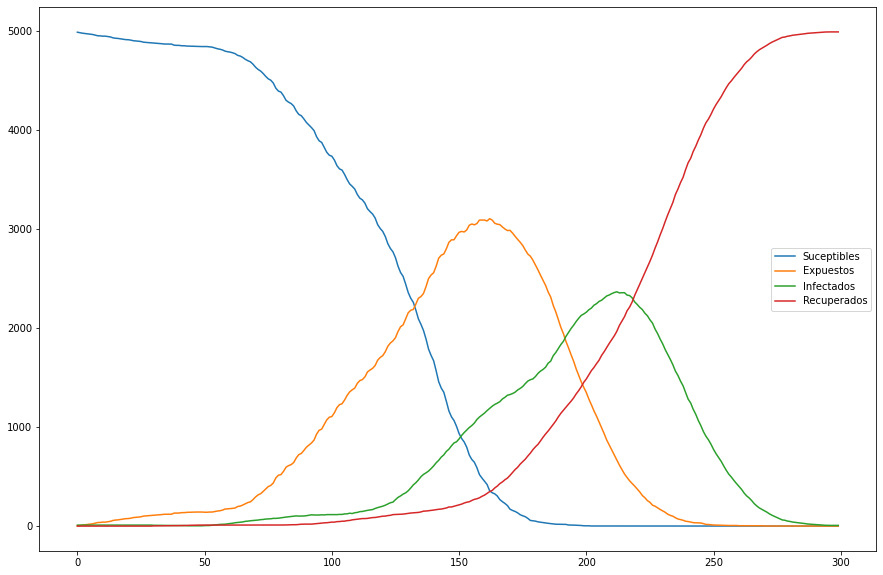

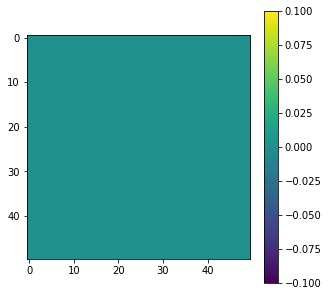

In [3]:
%matplotlib inline
from modulos.Ambiente.ambiente import Ciudad
from modulos.Individuos.individuo import Individuo_2

#Se define el número de agentes y de pasos
n_agentes = 5000
n_steps = 300

#Se definen los atributos predefinidos de los agentes
attrs_individuos = {#Atributos de comportamiento
                    'evitar_agentes': True,
                    'en_cuarentena': False,
                    'quedate_en_casa': False,
                    #Atributos ante la enfermedad
                    'prob_contagiar': 0.5,
                    'prob_infectarse': 0.8,
                    'radio_de_infeccion': 0
                    }
modelo = Modelo(n_agentes, Ciudad, Individuo_2,
                ind_attrs = attrs_individuos)
modelo.agregar_lugar('ciudad', tamano = 50)

for _ in range(n_steps):
    modelo.step()
datos = modelo.datacollector.get_model_vars_dataframe()
datos.head()
datos.plot(figsize = (15,10));

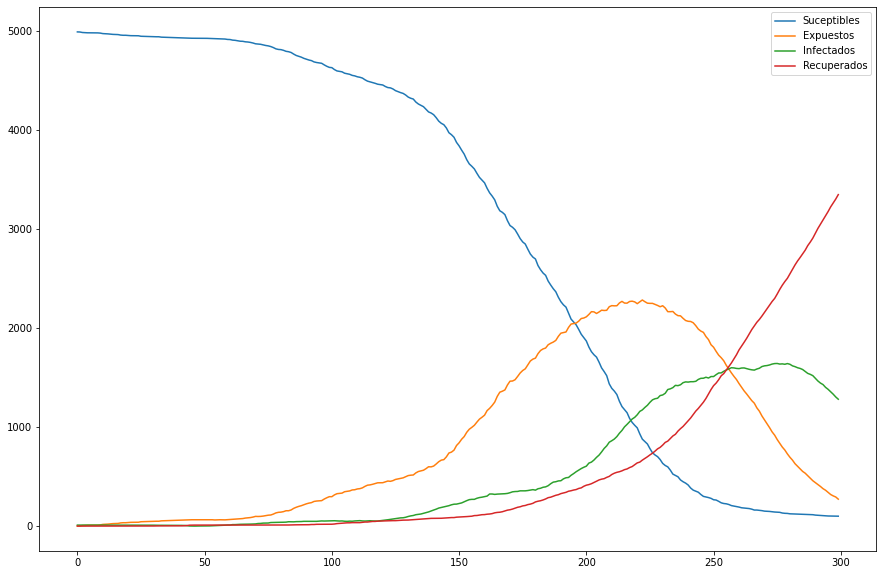

In [5]:
n_steps = 300

#Se definen los atributos predefinidos de los agentes
attrs_individuos = {#Atributos de comportamiento
                    'evitar_agentes': True,
                    'en_cuarentena': False,
                    'quedate_en_casa': True,
                    #Atributos ante la enfermedad
                    'prob_contagiar': 0.5,
                    'prob_infectarse': 0.8,
                    'radio_de_infeccion': 0
                    }
modelo = Modelo(n_agentes, Ciudad, Individuo_2,
                ind_attrs = attrs_individuos)
modelo.agregar_lugar('ciudad', tamano = 50)

for _ in range(n_steps):
    modelo.step()
datos = modelo.datacollector.get_model_vars_dataframe()
datos.head()
datos.plot(figsize = (15,10));